In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Process Logs").getOrCreate()
spark

In [18]:
import re
from pyspark.sql import functions as F, types as T

In [2]:
import os
print(os.cpu_count())

32


# Apache Access Logs

In [3]:
df_2004 = spark.read.text("data/linux_2004/log/httpd/access_log*")
print(df_2004.count())

38487


In [4]:
df_2005 = spark.read.text("data/linux_2005/log/httpd/access_log*")
print(df_2005.count())

5936


In [5]:
df_2006 = spark.read.text("data/linux_2006/log/httpd/access_log*")
print(df_2006.count())

36310


In [6]:
df_access = spark.read.text("data/apache/access.log")
print(df_access.count())

6016792


## Combine into single DataFrame

In [22]:
%%time
raw_df = df_access.union(df_2004.union(df_2005.union(df_2006))).where("value <> ''")
total = raw_df.count()
print(total)

6097524
CPU times: user 1.95 ms, sys: 148 µs, total: 2.09 ms
Wall time: 362 ms


In [23]:
print(raw_df.rdd.getNumPartitions())

90


# EDA

In [25]:
%%time
distinct_raw_df = spark.createDataFrame(raw_df.rdd.distinct())
print(distinct_raw_df.count())

4256760
CPU times: user 251 ms, sys: 23.1 ms, total: 274 ms
Wall time: 10.8 s


In [26]:
%%time
sample_df = raw_df.sample(fraction=10/total)
print(sample_df.count())

15
CPU times: user 1.34 ms, sys: 0 ns, total: 1.34 ms
Wall time: 368 ms


In [27]:
sample = list(map(lambda x: x['value'], sample_df.collect()))

## Using Regular Expressions for extracting the fields of the log as columns

In [28]:
log_fields = ('IP', 'UserIdentity', 'Username', 'Timestamp', 'Request', 'StatusCode', 
              'Size(bytes)', 'Referrer', 'UserAgent')
pattern = r'(.+) (.+) (.+) \[(.+)\] "(.+)" (\d+) (\d+) "(.+?)" "(.+?)"'

#### Some re pattern explanations
<pre>
(.+?) - non-greedy matching
(".+")? - optional group
</pre>

### Using regexp_extract function

In [32]:
%%time
extracted_df = raw_df.select(F.regexp_extract("value", pattern, 1).alias('IP'),
                             F.regexp_extract("value", pattern, 2).alias('UserIdentity'),
                             F.regexp_extract("value", pattern, 3).alias('Username'),
                             F.to_timestamp(F.regexp_extract("value", pattern, 4), 'dd/MMM/yyyy:HH:mm:ss Z').alias('Timestamp'),
                             F.regexp_extract("value", pattern, 5).alias('Request'),
                             F.regexp_extract("value", pattern, 6).cast("integer").alias('StatusCode'),
                             F.regexp_extract("value", pattern, 7).cast("integer").alias('Size(bytes)'),
                             F.regexp_extract("value", pattern, 8).alias('Referrer'),
                             F.regexp_extract("value", pattern, 9).alias('UserAgent')
                             ).cache()
print(extracted_df.count())

6097524
CPU times: user 97.7 ms, sys: 15.5 ms, total: 113 ms
Wall time: 24min 21s


In [33]:
extracted_df.show(5)

+---------------+------------+--------+-------------------+--------------------+----------+-----------+--------------------+--------------------+
|             IP|UserIdentity|Username|          Timestamp|             Request|StatusCode|Size(bytes)|            Referrer|           UserAgent|
+---------------+------------+--------+-------------------+--------------------+----------+-----------+--------------------+--------------------+
|109.169.248.247|           -|       -|2015-12-12 17:25:11|GET /administrato...|       200|       4263|                   -|Mozilla/5.0 (Wind...|
|109.169.248.247|           -|       -|2015-12-12 17:25:11|POST /administrat...|       200|       4494|http://almhuette-...|Mozilla/5.0 (Wind...|
|    46.72.177.4|           -|       -|2015-12-12 17:31:08|GET /administrato...|       200|       4263|                   -|Mozilla/5.0 (Wind...|
|    46.72.177.4|           -|       -|2015-12-12 17:31:08|POST /administrat...|       200|       4494|http://almhuette-...|

# Analyze IP addresses

In [34]:
import pandas as pd
import requests
import json

In [252]:
%%time
ips = extracted_df.select("IP").where("IP <> ''").distinct()
print(f"We have a total of {ips.count()} unique visitors")

We have a total of 90015 unique visitors
CPU times: user 743 ms, sys: 1.43 ms, total: 744 ms
Wall time: 1.59 s


## Number of unique daily hosts

In [ ]:
Window
  .PartitionBy("id")
  .OrderBy(F.col("date").cast("timestamp").cast("long"))
  .RangeBetween((int64)((-7)*60*60*24), (int64)((-1)*60*60*24))

In [ ]:
df.select(F.count("IP").over(winSpec)).show()

## IP Address Locations

### Clean the locations data scraped from the Web

In [246]:
%%time
l_df = spark.read.json('iplocation/IPLocation.json').distinct().cache()\
                .where(F.col("_corrupt_record").isNull()).drop("_corrupt_record")
l_df.count()

CPU times: user 2.64 ms, sys: 36 µs, total: 2.67 ms
Wall time: 3.95 s


90001

#### Left Anti-join show rows from the left which are not present in right

In [241]:
ips.join(locations_df, ips.IP==l_df.ip, how="left_anti").show(truncate=False)

+------------------------------------+
|IP                                  |
+------------------------------------+
|217.216.115.198.dyn.user.ono.com    |
|pcp740115pcs.reston01.va.comcast.net|
|                                    |
|200.163.13.65                       |
|142.93.239.94                       |
|218.2.191.31                        |
|194.54.152.8                        |
|66.102.9.31                         |
|62.117.154.141                      |
|85.26.165.151                       |
|128.69.19.250                       |
|90.151.94.131                       |
|109.225.31.60                       |
|23.254.49.21                        |
|54.189.60.10                        |
+------------------------------------+



In [247]:
l_pdf = locations_df.toPandas()

In [255]:
# Added ip locations info manually for the above records
l_pdf = l_pdf.append(manual)

In [257]:
l_pdf.to_json('data/locations.json', orient='records', lines=True)

In [258]:
l_df.unpersist()

DataFrame[city: string, country: string, hostname: string, ip: string, loc: string, org: string, postal: string, readme: string, region: string, timezone: string]

### Load the Cleaned Location data

In [260]:
%%time
locations_df = spark.read.json('data/locations.json')
locations_df.count()

CPU times: user 1.09 ms, sys: 963 µs, total: 2.05 ms
Wall time: 3.16 s


90015

#### Check for any missing IP locations info

In [262]:
ips.join(locations_df, ips.IP==locations_df.ip, how="left_anti").show(truncate=False)

+---+
|IP |
+---+
+---+



### Join with original df

In [264]:
ips_locations = ips.join(locations_df, ips.IP==locations_df.ip, how="inner")
ips_locations.count()

90015

# Analyze HTTP Requests

In [51]:
req = extracted_df.select("Request", "StatusCode", "Size(bytes)").where("Request <> ''")
req.count()

6084776

## Analyze Request text

In [52]:
splitCol = F.split('Request', " ")
req_text = req.withColumn('Type', splitCol.getItem(0))\
                .withColumn('Page', splitCol.getItem(1))\
                .withColumn('Protocol', splitCol.getItem(2))
req_text.show(3)

+--------------------+----------+-----------+----+--------------------+--------+
|             Request|StatusCode|Size(bytes)|Type|                Page|Protocol|
+--------------------+----------+-----------+----+--------------------+--------+
|GET /administrato...|       200|       4263| GET|     /administrator/|HTTP/1.1|
|POST /administrat...|       200|       4494|POST|/administrator/in...|HTTP/1.1|
|GET /administrato...|       200|       4263| GET|     /administrator/|HTTP/1.1|
+--------------------+----------+-----------+----+--------------------+--------+
only showing top 3 rows



## Analyze Type of Request
### Type of successful(200) Requests and their counts

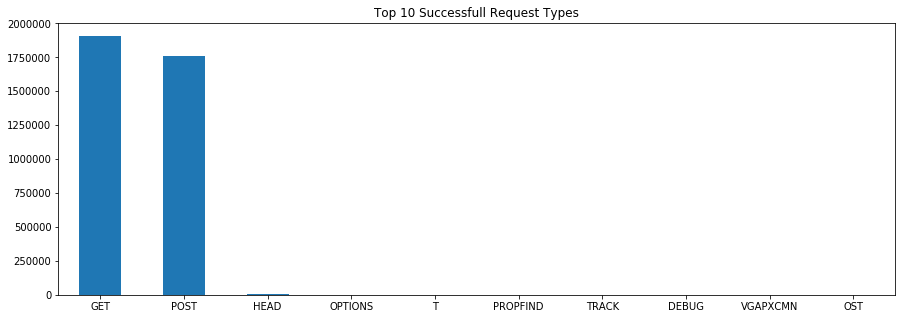

In [298]:
req_type_counts = req_text.filter("StatusCode = 200").groupBy("Type").count().orderBy(F.desc("count")).limit(10).toPandas().set_index("Type")
# For better visual
req_type_counts.index = list(map(lambda x: x[-10:], req_type_counts.index))
ax = req_type_counts.plot(kind="bar", rot=0, figsize=(15, 5), legend=False)
ax.set_title("Top 10 Successfull Request Types");

## Analyze Status Codes

### Erroneous Pages

In [95]:
df_errors = req_text.filter("StatusCode <> 200")
print(f"We have {df_errors.distinct().count()} Erroneous Pages")

We have 199094 Erroneous Pages


In [97]:
print("Most frequent Erroneous Endpoints")
df_errors.groupBy("Page", "StatusCode").count().orderBy(F.desc("count")).toPandas().set_index("Page")

Most frequent Erroneous Endpoints


,StatusCode,count
Page,,
/apache-log/access.log,206,1519675
/index.php?option=com_contact&view=contact&id=1,303,143128
/templates/_system/css/general.css,404,38664
/favicon.ico,404,24999
/admin%24,404,10533
...,...,...
/cgi-bin/cgiforum.pl?thesection=../../../../../../../../../../etc/passwd%00,404,1
/cgi-bin/ion-p.exe?page=c:\winnt\repair\sam,404,1
/cgi-bin/query?mss=%2e%2e/config,404,1


### 404 Not Found links

In [104]:
df_404 = req_text.filter("StatusCode = 404")
print(f"We have a total of {df_404.count()} '404 Not found' errors, The Top 10 most frequent ones are as below")
df_404.groupBy("Page").count().orderBy(F.desc("count")).limit(10).toPandas().set_index("Page")

We have a total of 708778 '404 Not found' errors, The Top 10 most frequent ones are as below


,count
Page,
/templates/_system/css/general.css,38664
/favicon.ico,24999
/admin%24,10533
/wp-login.php,9564
/apple-touch-icon.png,4671
/apple-touch-icon-precomposed.png,4606
/c%24,4314
/apple-touch-icon-120x120-precomposed.png,4290
/apple-touch-icon-120x120.png,4289


### Protocols Used

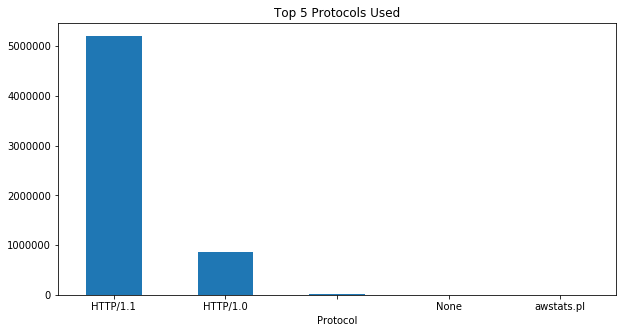

In [301]:
df_protocol = req_text.groupBy("Protocol").count().orderBy(F.desc("count")).limit(5).toPandas().set_index("Protocol")
ax = df_protocol.plot(kind="bar", rot=0, figsize=(10, 5), legend=False)
ax.set_title("Top 5 Protocols Used");

## Analyze Response size

In [109]:
size = req.select(F.col("Size(bytes)").alias("Size"))

In [121]:
print("Maximum and minimum response sizes")
size.select((F.max("Size") / 1e9).alias("Max Size(GB)"), F.min("Size")).show()

Maximum and minimum response sizes
+------------+---------+
|Max Size(GB)|min(Size)|
+------------+---------+
| 1.220959388|        0|
+------------+---------+



In [147]:
print("Frquency of Response Size (in bytes)")
size_counts = size.groupBy("Size").count().orderBy("count").toPandas().set_index("Size").sort_values("count", ascending=False)
size_counts[:10]

Frquency of Response Size (in bytes)


,count
Size,
4481,699414
4270,595539
4498,550697
4501,299561
4494,175483
9873,160449
5,148370
43192,140815
12272,136628


### Bucket using Normal UDF

In [131]:
def bucket(x):
    if x <= 1e3:
        return "<=1KB"
    elif x < 1e6:
        return "1KB-1MB"
    elif x < 100e6:
        return "1-100MB"
    elif x < 1e9:
        return "0.5-1GB"
    return ">1GB"

bucket_udf = F.udf(bucket, T.StringType())

In [132]:
%%time
bucketed_df_udf = size.select("Size", bucket_udf("Size").alias("Bucket"))
bucketed_df_udf.count()

CPU times: user 4.63 ms, sys: 94 µs, total: 4.72 ms
Wall time: 92.5 ms


6084776

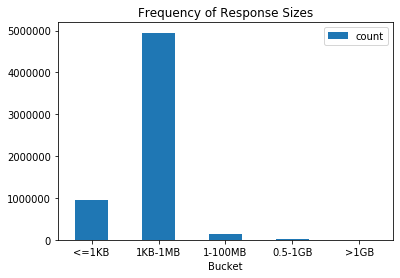

In [145]:
bucket_counts = bucketed_df_udf.groupBy("Bucket").count().toPandas().set_index("Bucket")
ax = bucket_counts.loc[["<=1KB","1KB-1MB","1-100MB","0.5-1GB",">1GB"]].plot(kind="bar", rot=0)
ax.set_title("Frequency of Response Sizes");

### Bucket Using Pandas UDF

In [160]:
def batch_fn(iterator):
    for pdf in iterator:
        pdf['Bucket'] = pdf.Size.apply(bucket)
        yield pdf

In [161]:
%%time
bucketed_df = size.mapInPandas(batch_fn, schema="Size integer, Bucket string")
bucketed_df.count()

CPU times: user 8.85 ms, sys: 2.92 ms, total: 11.8 ms
Wall time: 1.12 s


6084776

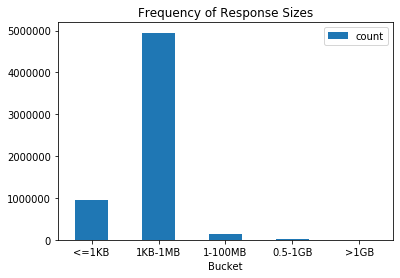

In [162]:
bucket_counts = bucketed_df.groupBy("Bucket").count().toPandas().set_index("Bucket")
ax = bucket_counts.loc[["<=1KB","1KB-1MB","1-100MB","0.5-1GB",">1GB"]].plot(kind="bar", rot=0)
ax.set_title("Frequency of Response Sizes");

# Analyze User-Agents

In [186]:
ua_pattern = r'(.+?)/(\S+)\s?(\(.+\))?\s?(.+)?'

In [188]:
ua = extracted_df.select(F.regexp_extract("UserAgent", ua_pattern, 1).alias("Browser"),
                         F.regexp_extract("UserAgent", ua_pattern, 2).alias("Version"),
                         F.regexp_extract("UserAgent", ua_pattern, 3).alias("PlatformInfo"),
                         F.regexp_extract("UserAgent", ua_pattern, 4).alias("Info")
                        )

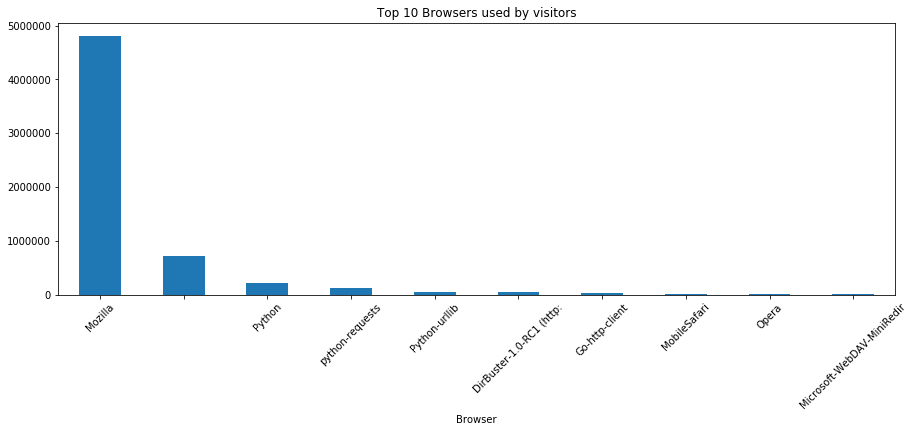

In [287]:
browser_counts = ua.groupBy("Browser").count().orderBy(F.desc("count")).limit(10).toPandas().set_index("Browser")
ax = browser_counts.plot(kind="bar", rot=45, figsize=(15, 5), legend=False)
ax.set_title("Top 10 Browsers used by visitors");

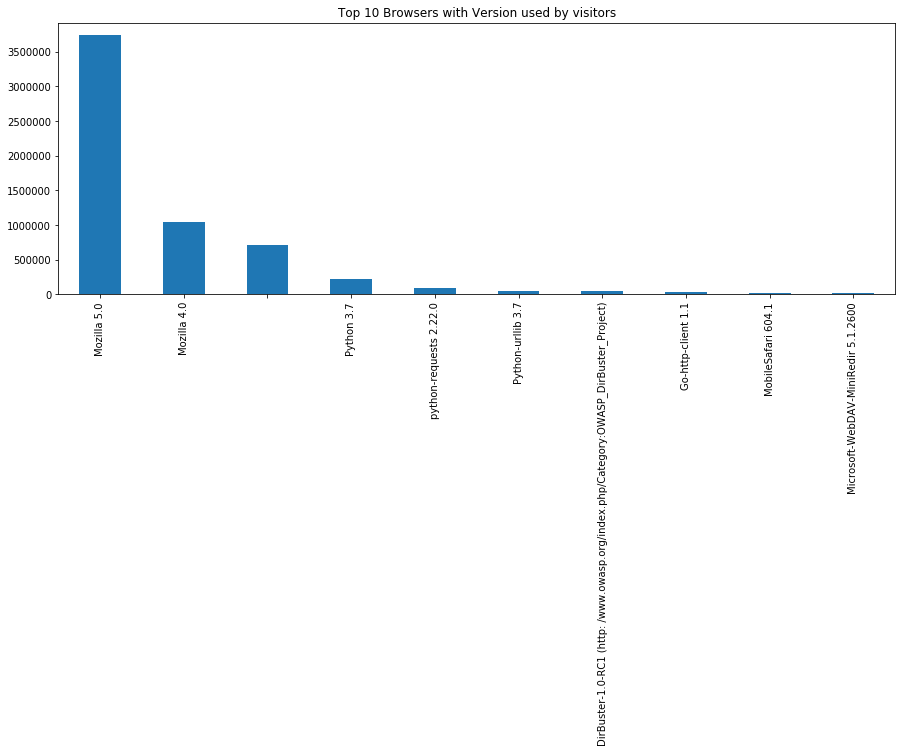

In [282]:
browser_version_counts = ua.groupBy("Browser", "Version").count().orderBy(F.desc("count")).limit(10).toPandas()
ax = browser_version_counts.plot(kind="bar", figsize=(15, 5), legend=False)
ax.set_xticklabels(browser_version_counts.Browser + " " + browser_version_counts.Version)
ax.set_title("Top 10 Browsers with Version used by visitors");

In [198]:
print("Summary of total and subtotal of Browsers with their versions used")
ua.rollup("Browser", "Version").count().orderBy(F.desc("count")).limit(10).toPandas()

Summary of total and subtotal of Browsers with their versions used


,Browser,Version,count
0,None,None,6097524
1,Mozilla,None,4806158
2,Mozilla,5.0,3733810
3,Mozilla,4.0,1045055
4,,,714311
5,,None,714311
6,Python,None,221995
7,Python,3.7,221979
8,python-requests,None,120072
9,python-requests,2.22.0,93989


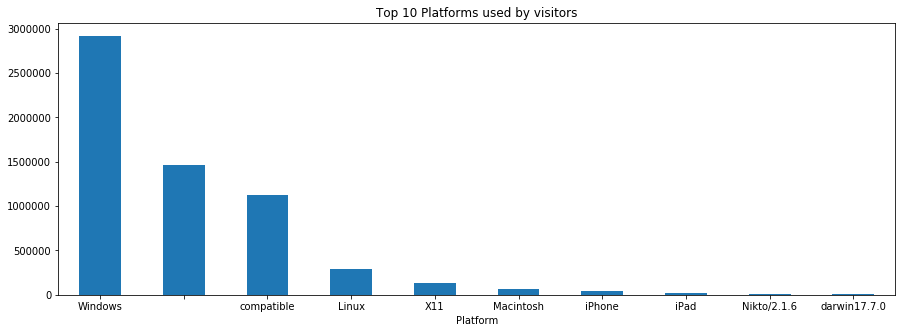

In [283]:
platform_counts = ua.groupBy(F.split(F.split("PlatformInfo", ";").getItem(0), " ").getItem(0)\
                            .alias("Platform")).count().orderBy(F.desc("count")).limit(10).toPandas()
platform_counts.Platform = platform_counts.Platform.str.strip("()")
platform_counts = platform_counts.set_index("Platform")
ax = platform_counts.plot(kind="bar", rot=0, figsize=(15, 5), legend=False)
ax.set_title("Top 10 Platforms used by visitors");

## Time-based Analysis

In [14]:
import time

## Don't forget to clean up

In [ ]:
extracted_df.unpersist()
spark.stop()